# Adaptive QPE

**Download this notebook - {nb-download}`adaptive-qpe.ipynb`**

This example illustrates a possible implementation of a quantum algorithm in Guppy, showcasing the possible integration, usage and pitfalls of features including:
- [Control flow](https://docs.quantinuum.com/guppy/language_guide/control_flow.html)
- [Compile time expressions](https://docs.quantinuum.com/guppy/language_guide/comptime.html), especially for referencing global constants

The implemented algorithm is the basic adaptive random walk phase estimation algorithm found at [arXiv:2208.04526](https://arxiv.org/abs/2208.04526) (Alg. 1 with sampling circuit from Fig. 1), with an example Hamiltonian and numbers taken from [arXiv:2206.12950](https://arxiv.org/abs/2206.12950) (Section V.B).

## Setup

We begin by specifying the example Hamiltonian in use, in this case $H = 0.5 * Z$, in two variants:
1. The unitary oracle $U(t) = R_Z[-0.5t]$ generated by the Hamiltonian, *and*
2. An eigenstate $\ket{0}$ of the Hamiltonian.

Although this may seem redundant, we will need both for executing the algorithm.

In [1]:
from guppylang import guppy
from guppylang.std.quantum import qubit, crz


@guppy
def oracle(ctrl: qubit, q: qubit, t: float) -> None:
    """Applies a controlled e^-iπHt/2 gate for the example Hamiltonian H = 0.5 * Z."""
    crz(ctrl, q, angle(0.5 * t))


@guppy
def eigenstate() -> qubit:
    """Prepares eigenstate of the example Hamiltonian H = 0.5 * Z."""
    q = qubit()
    x(q)
    return q

## Algorithm

The algorithm roughly performs the following steps on each iteration, which are outlined below:
1. Sample from a distribution generated by a circuit involving the eigenstate, an iteration-specific ancilla and the oracle (see Fig. 1 of [arXiv:2208.04526](https://arxiv.org/abs/2208.04526)).
2. Based on the outcome, step the phase estimate up or down by a fixed amount.
3. Decrease the step size by a fixed amount.

Following [arXiv:2206.12950](https://arxiv.org/abs/2206.12950) (Fig. 4), we use 24 such iterations, and finally record the phase estimate using `result`.


In [2]:
import math
from guppylang.std.angles import angle
from guppylang.std.builtins import comptime, result
from guppylang.std.quantum import discard, measure, h, rz, x

sqrt_e = math.sqrt(math.e)
sqrt_e_div = math.sqrt((math.e - 1) / math.e)


@guppy
def main() -> None:
    # Pick initial estimate of phase mean and stdv
    # and prepare eigenstate
    mu, sigma = comptime(sqrt_e_div), 1 / comptime(sqrt_e)
    tgt = eigenstate()

    for _ in range(24):
        t = 1 / sigma

        # Sample from the phase estimate distribution
        aux = qubit()
        h(aux)
        rz(aux, angle((sigma - mu) * t))
        oracle(aux, tgt, t)
        h(aux)
        outcome = measure(aux)

        # Adjust estimate and step size
        if outcome:
            mu += sigma / comptime(sqrt_e)
        else:
            mu -= sigma / comptime(sqrt_e)
        sigma *= comptime(sqrt_e_div)

    discard(tgt)
    result("eigenvalue", 2 * mu)

main.check()

Note that the implementation uses [`comptime`](https://docs.quantinuum.com/guppy/language_guide/comptime.html) expressions to reference the constants `sqrt_e` and `sqrt_e_div` since they are defined outside the function annotated with `@guppy`.

One may ask why expressions involving `sigma` and these constants are not entirely wrapped in [`comptime`](https://docs.quantinuum.com/guppy/language_guide/comptime.html). This uncovers a subtlety of such wrapping: [`comptime`](https://docs.quantinuum.com/guppy/language_guide/comptime.html) expressions are only evaluated *once* during compile time, and thus cannot react to changing variables such as `sigma`.

## Testing and Evaluation

We test the implementation by creating an emulator and allocating the maximum number of qubits: One holding the eigenstate and one ancilla that will be reused. Running the emulator once yields an example result:

In [3]:
emulator = main.emulator(n_qubits=2).with_seed(2)
emulator.run()

EmulatorResult(results=[QsysShot(entries=[('eigenvalue', 2.3679925580437398)])])

However, this is not guaranteed to be the actual phase of our example Hamiltonian, as it is only one example drawn from a distribution. We thus run a larger number of shots, extract the recorded phase from each and visualize them using `matplotlib`. Doing this reveals the expected phase of the Hamiltonian as the highest peak in the histogram.

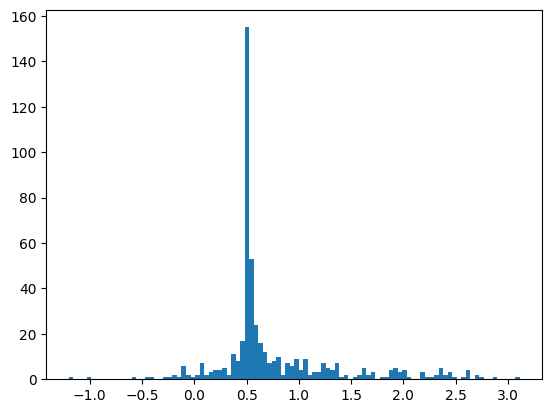

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

shots = emulator.with_shots(500).run()

fig, ax = plt.subplots(1, 1)
ax.hist([shot.as_dict()["eigenvalue"] for shot in shots], bins=100)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.show()